In [51]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.image as mpimg  # Thư viện để đọc ảnh

import numpy as np
from shapely.geometry import LineString

# Số điểm trên hình tròn
n_points = 20
radius = 1.5

# Tính tọa độ các điểm trên hình tròn
angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
x = radius * np.cos(angles)
y = radius * np.sin(angles)

# Tạo các đoạn thẳng
lines = []
for i in range(n_points):
    for j in range(i + 1, n_points):
        line = LineString([(x[i], y[i]), (x[j], y[j])])
        lines.append(line)

# Tìm các giao điểm
intersections = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        intersection = lines[i].intersection(lines[j])
        if intersection.is_empty:
            continue
        if intersection.geom_type == 'Point':
            intersections.append((intersection.x, intersection.y))
        elif intersection.geom_type == 'MultiPoint':
            for point in intersection:
                intersections.append((point.x, point.y))

# Lọc các điểm giao trùng lặp (nếu cần)
unique_intersections = list(set(intersections))

# Tạo DataFrame
df_intersections = pd.DataFrame(unique_intersections, columns=['x', 'y'])

# Hiển thị kết quả
df_intersections


,x,y
0,-0.303805,4.181524e-01
1,-1.036475,3.367710e-01
2,-0.881678,-9.342374e-01
3,0.237577,7.730114e-17
4,-0.390110,9.630593e-01
...,...,...
4624,-0.286475,-6.183221e-01
4625,-0.750000,9.550931e-01
4626,0.726881,2.361780e-01
4627,-0.868788,6.312117e-01


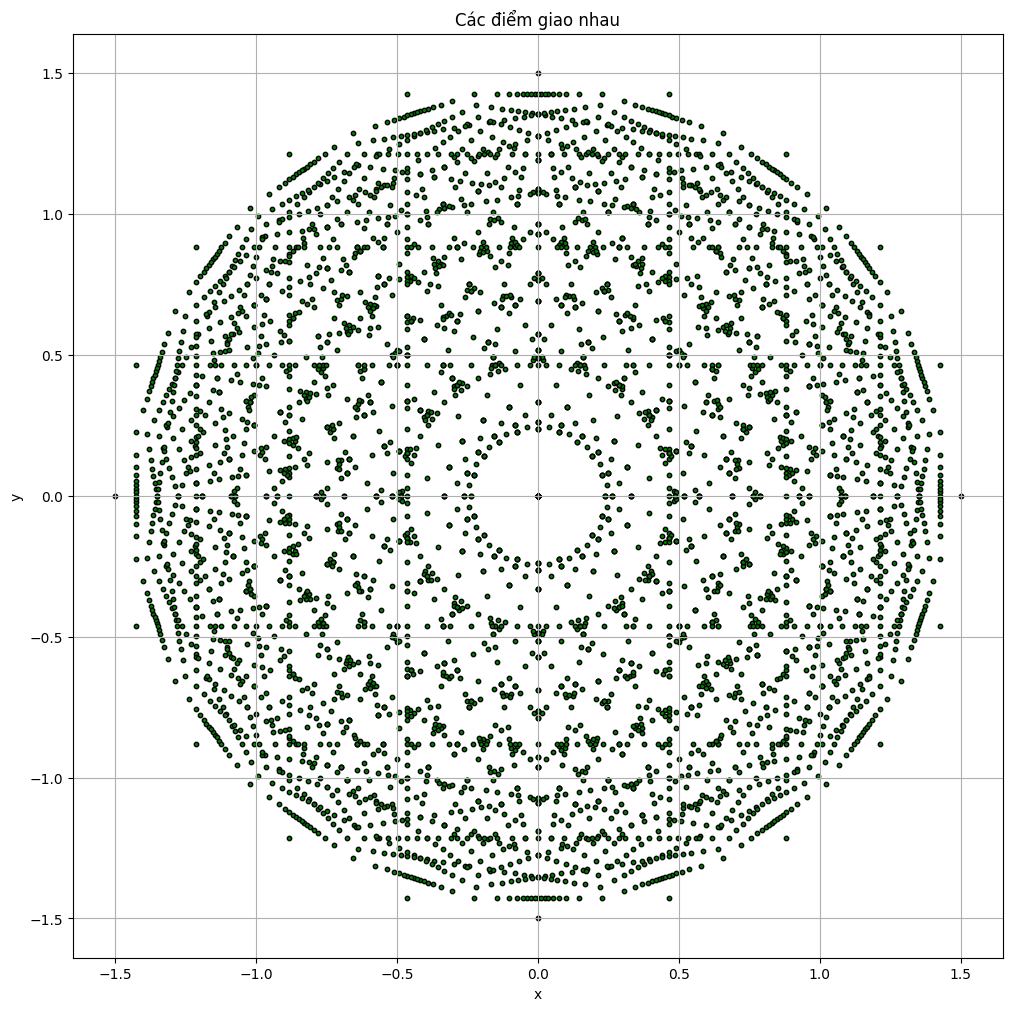

In [61]:
plt.figure(figsize=(12, 12))
plt.scatter(df_intersections['x'], df_intersections['y'], color='green', s=10, edgecolor='black')  # s nhỏ hơn, marker mặc định hình tròn
plt.title('Các điểm giao nhau')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')  # Giữ tỉ lệ đều giữa trục x và y
plt.grid(True)
plt.show()

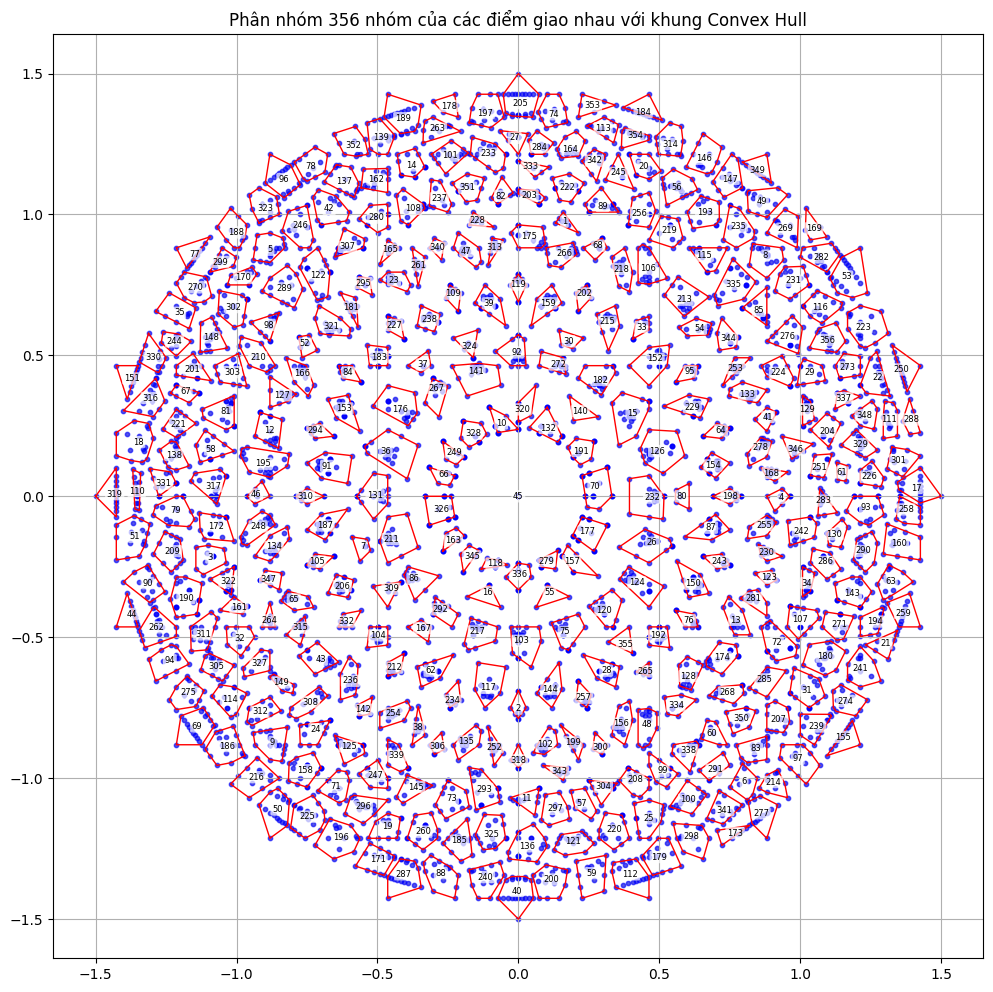

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

points = df_intersections[['x', 'y']].values
n_clusters = 356

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(points)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(12, 12))

# Vẽ tất cả điểm nhỏ màu xám để làm nền
plt.scatter(points[:, 0], points[:, 1], color='gray', s=5, alpha=0.3)

# Vẽ khung Convex Hull cho mỗi nhóm
for cluster_id in range(n_clusters):
    cluster_points = points[labels == cluster_id]
    if len(cluster_points) < 3:
        # Không thể tạo hull nếu dưới 3 điểm, vẽ điểm thôi
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, color='blue')
        continue
    
    hull = ConvexHull(cluster_points)
    hull_points = cluster_points[hull.vertices]
    
    # Vẽ đường viền hull, đóng kín đa giác
    plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]),
             np.append(hull_points[:, 1], hull_points[0, 1]),
             'r-', linewidth=1)
    
    # Vẽ điểm nhóm màu xanh
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, color='blue', alpha=0.6)

# Ghi nhãn nhóm tại tâm cụm
for i, (x_cent, y_cent) in enumerate(centroids, 1):
    plt.text(x_cent, y_cent, str(i), fontsize=6, ha='center', va='center', color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

plt.title(f'Phân nhóm {n_clusters} nhóm của các điểm giao nhau với khung Convex Hull')
plt.axis('equal')
plt.grid(True)
plt.show()




In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df_intersections đã tồn tại
points = df_intersections[['x', 'y']].values

# Chia thành 40 x 40 ô từ -1.5 đến 1.5
n_bins = 21
x_bins = np.linspace(-1.5, 1.5, n_bins + 1)
y_bins = np.linspace(-1.5, 1.5, n_bins + 1)

# Gán chỉ số ô (i, j) cho từng điểm
x_indices = np.digitize(points[:, 0], x_bins) - 1
y_indices = np.digitize(points[:, 1], y_bins) - 1

# Đảm bảo nằm trong chỉ số hợp lệ (0–39)
x_indices = np.clip(x_indices, 0, n_bins - 1)
y_indices = np.clip(y_indices, 0, n_bins - 1)

# Mỗi nhóm là (row, col) → đổi thành 1 số duy nhất: group_id = row * 40 + col
group_ids = y_indices * n_bins + x_indices

# Gán vào DataFrame
df_grid_clustered = df_intersections.copy()
df_grid_clustered['group'] = group_ids


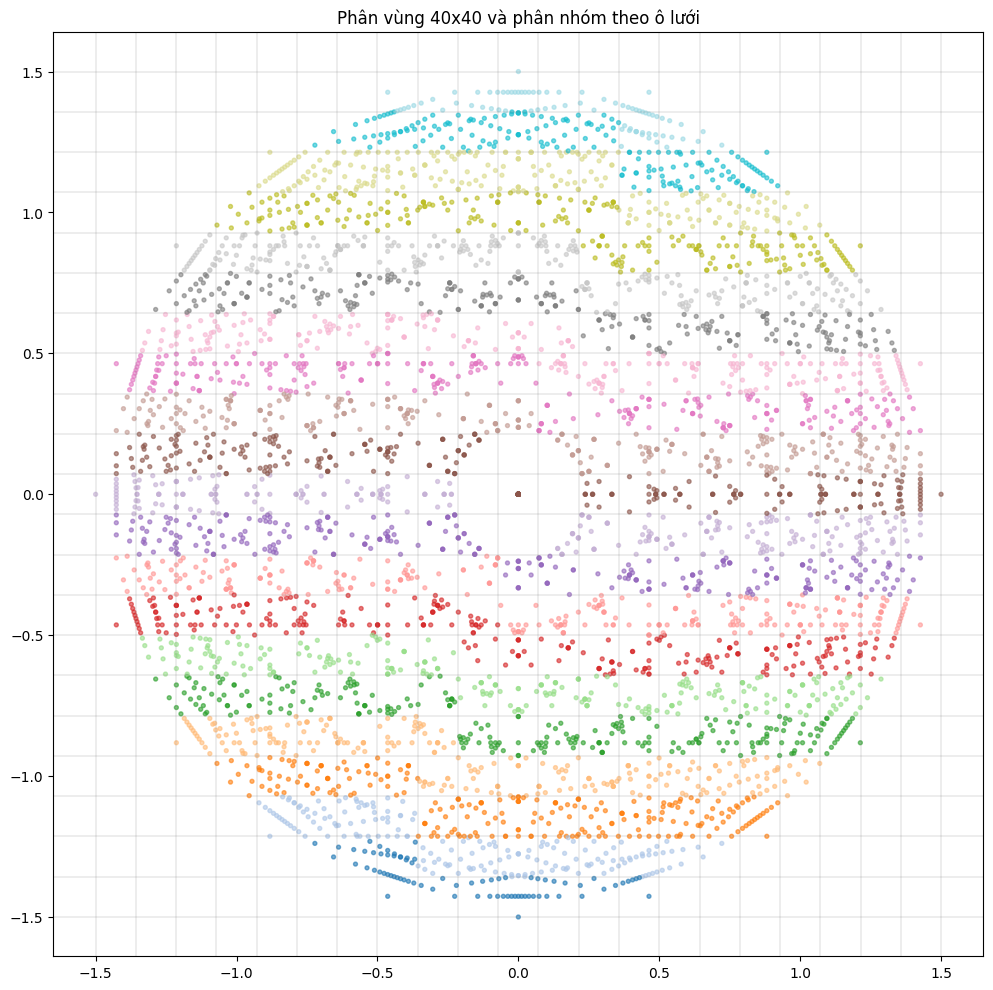

In [95]:
plt.figure(figsize=(12, 12))

# Vẽ các điểm theo nhóm màu
scatter = plt.scatter(df_grid_clustered['x'], df_grid_clustered['y'], c=df_grid_clustered['group'],
                      cmap='tab20', s=8, alpha=0.6)

# Vẽ lưới 40x40 từ -1.5 đến 1.5
for i in range(n_bins + 1):
    x_line = -1.5 + i * (3.0 / n_bins)
    plt.axvline(x_line, color='gray', linewidth=0.2)

    y_line = -1.5 + i * (3.0 / n_bins)
    plt.axhline(y_line, color='gray', linewidth=0.2)

plt.title('Phân vùng 40x40 và phân nhóm theo ô lưới')
plt.axis('equal')
plt.grid(False)
plt.show()


In [97]:
group_stats = df_grid_clustered['group'].value_counts().sort_index().reset_index()
group_stats.columns = ['group_id', 'num_points']
print(f"Tổng số nhóm có điểm: {len(group_stats)}")
group_stats

Tổng số nhóm có điểm: 345


,group_id,num_points
0,7,6
1,8,5
2,9,6
3,10,14
4,11,6
...,...,...
340,429,6
341,430,14
342,431,6
343,432,5
